In [2]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dalex as dx #explainer for our model
from numpy import absolute
from numpy import mean
from numpy import std
from numpy import arange

#sklearn 
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, log_loss, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV


# XGB
import xgboost as xgb
from xgboost import XGBRegressor
xgb.set_config(verbosity=0) # to supress warnings

# shap
import shap

#joblib to save trained models
import joblib

# Show pipelines as interactive diagram
from sklearn import set_config; set_config(display='diagram')

#Compare Models
from regressormetricgraphplot import *

In [3]:
# Set random seed for reproducibility reasons
np.random.seed(42)

In [4]:
import sklearn, matplotlib
print("Installed/ Used versions:")
print("python: 3.8.6")
print("sklearn:", sklearn.__version__)
print("shap:", shap.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)
print("joblib:", joblib.__version__)


Installed/ Used versions:
python: 3.8.6
sklearn: 1.0.1
shap: 0.40.0
numpy: 1.19.5
pandas: 1.2.5
matplotlib: 3.4.2
seaborn: 0.11.1
joblib: 1.0.1


# 1. Importing the Clean Dataset

In [5]:
url = 'https://github.com/Heity94/Compas-recidivism-analysis/blob/master/data-cleaned/compas-scores-two-years-clean.csv?raw=true'
df = pd.read_csv(url, parse_dates=["c_jail_in", "c_jail_out"])
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,score_text,v_type_of_assessment,v_decile_score,v_score_text,in_custody,out_custody,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,Risk of Violence,1,Low,2014-07-07,2014-07-14,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,Risk of Violence,1,Low,2013-01-26,2013-02-05,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,Risk of Violence,3,Low,2013-06-16,2013-06-16,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,High,Risk of Violence,6,Medium,NaN,NaN,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,Risk of Violence,1,Low,NaN,NaN,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,10995,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,...,High,Risk of Violence,9,High,2014-04-07,2014-04-27,0,169,0,0
6212,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,Medium,Risk of Violence,5,Medium,2013-11-22,2013-11-24,1,860,0,0
6213,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,Low,Risk of Violence,5,Medium,2014-01-31,2014-02-02,1,790,0,0
6214,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,Low,Risk of Violence,1,Low,2014-01-13,2014-01-14,0,808,0,0


# 2. Feature Engineering: Create feature c_charge_degree_detailed

In [6]:
# There are 358 unique charges in the dataset in total (wo NaN)
print("Unique charges in the dataset:", len(df.c_charge_desc.unique()))

# There are 265 unqiue charges for felonies (23 of them also exist in misdemeanor) (wo NaN)
print("Unique charges for felonies:", len(df[df["c_charge_degree"]=="F"]
                                          [["c_charge_degree", "c_charge_desc"]]
                                          .c_charge_desc.unique()))

# There are 125 unqiue charges for misdemeanors  (wo NaN)
print("Unique charges for misdemeanors:", len(df[df["c_charge_degree"]=="M"]
                                              [["c_charge_degree", "c_charge_desc"]]
                                              .c_charge_desc.unique()))


Unique charges in the dataset: 408
Unique charges for felonies: 295
Unique charges for misdemeanors: 149


* In order to reduce the variaty of charges we created a new feature to cluster each crime into the correct level
* The original dataset already contains the more detailed degree of crimes, but only for the recidivist crimes
* We first used these crimes and mapped them against the current charges

# 3. Map charge degree to all cases and store in new feature column c_charge_degree_detailed

In [7]:
# Load master lookup table
url2 = 'https://github.com/Heity94/Compas-recidivism-analysis/blob/master/notebooks/Philipp/labeled_charges_master.csv?raw=true'
labeled_charges_master = pd.read_csv(url2, index_col="c_charge_desc")

In [8]:
# Map charge degree to all cases and store in new column "c_charge_degree_detailed"
df= df.merge(labeled_charges_master, how="left", left_on="c_charge_desc", right_index=True)
df.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='c_charge_degree_detailed', ylabel='count'>

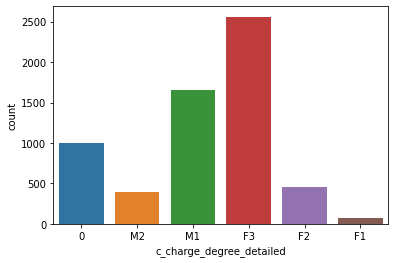

In [9]:
sns.countplot(x="c_charge_degree_detailed", data=df, order=["0","M2", "M1", "F3", "F2", "F1"])

In [10]:
#Check NaN values (values which did not have a c_charge_desc in the original dataset)
df[df.c_charge_degree_detailed.isnull()]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,in_custody,out_custody,start,end,event,two_year_recid,c_charge_degree_detailed
9,13,bo bradac,bo,bradac,2013-11-04,Male,1994-06-10,21,Less than 25,Caucasian,...,Risk of Violence,5,Medium,2015-01-06,2015-01-07,0,428,1,1,NaN
54,95,daquan davis,daquan,davis,2013-03-14,Male,1994-04-11,22,Less than 25,African-American,...,Risk of Violence,9,High,2013-05-23,2013-09-24,0,70,0,1,NaN
80,147,phillip bishop,phillip,bishop,2013-11-06,Male,1949-05-04,66,Greater than 45,Caucasian,...,Risk of Violence,1,Low,2013-09-03,2013-10-03,0,877,0,0,NaN
133,243,bryan sandrin,bryan,sandrin,2014-02-11,Male,1976-06-30,39,25 - 45,Caucasian,...,Risk of Violence,4,Low,2014-02-10,2014-02-14,3,780,0,0,NaN
160,285,charmaine ramkhelawan,charmaine,ramkhelawan,2013-07-22,Female,1964-04-16,52,Greater than 45,Other,...,Risk of Violence,1,Low,NaN,NaN,0,449,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5738,10143,joshua staley,joshua,staley,2013-05-14,Male,1989-09-14,26,25 - 45,African-American,...,Risk of Violence,5,Medium,2013-06-14,2013-06-25,0,31,0,0,NaN
6005,10588,sergio santibanez-cruz,sergio,santibanez-cruz,2013-03-13,Male,1990-09-08,25,25 - 45,Hispanic,...,Risk of Violence,3,Low,2013-01-29,2013-02-01,0,1115,0,0,NaN
6016,10611,edward eggers,edward,eggers,2013-10-24,Male,1961-05-01,54,Greater than 45,Caucasian,...,Risk of Violence,1,Low,2014-06-11,2014-07-18,0,101,1,1,NaN
6022,10624,marion davis,marion,davis,2013-02-07,Male,1988-02-26,28,25 - 45,African-American,...,Risk of Violence,3,Low,2013-02-07,2013-02-07,0,173,1,1,NaN


In [11]:
index_nan_cases = df[df.c_charge_degree_detailed.isnull()].index

# 4. Descriptive Statistics

In [12]:
df['race'].value_counts()

African-American    3139
Caucasian           2132
Hispanic             563
Other                340
Asian                 28
Native American       14
Name: race, dtype: int64

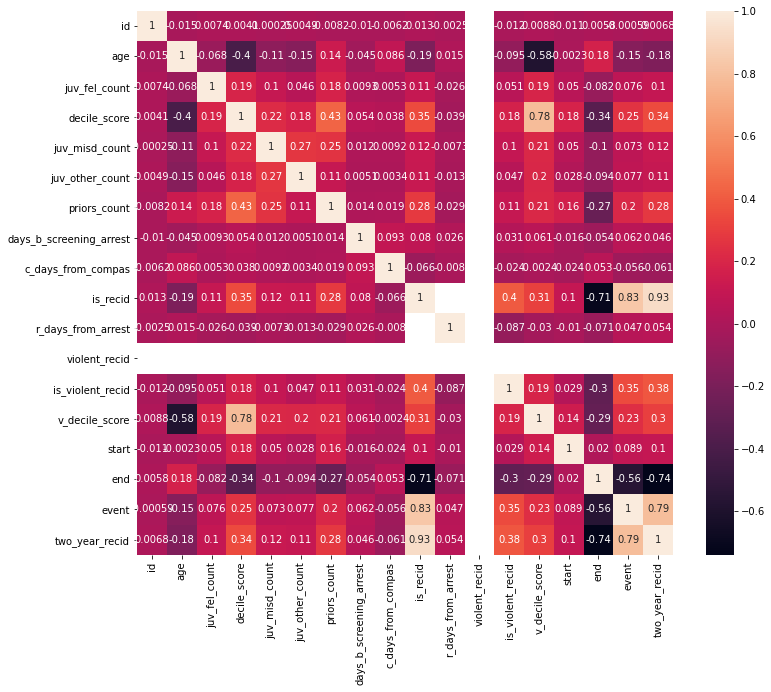

In [13]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True);

# 5. Taking the Log of Decile Score

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

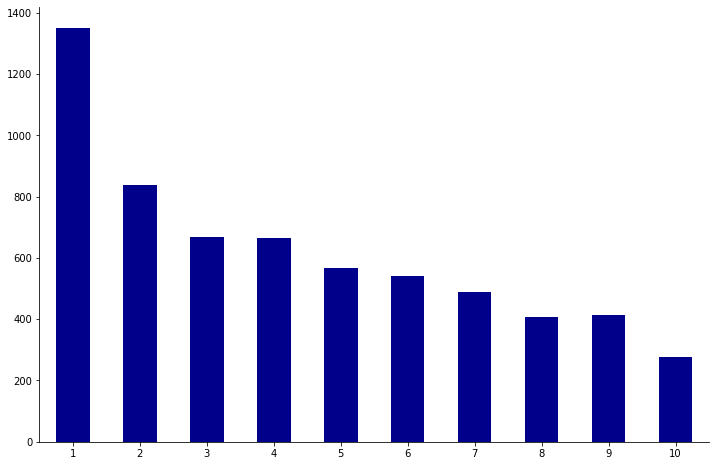

In [14]:
def create_groupcount_barplot(df, group_col, figsize, **kwargs):
    "call df.groupby(group_col), then count number of records and plot"
    counts = df.groupby(group_col)["name"].count().sort_index()

    fig, ax = plt.subplots(figsize=figsize)
    counts.plot(kind="bar", **kwargs)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("")
    ax.set_ylabel("")

    return fig, ax

create_groupcount_barplot(df, "decile_score", (12, 8), color="DarkBlue", rot=0)

In [15]:
df['decile_score_log'] = np.log(df.decile_score)

In [16]:
print(df.decile_score.skew())
print(df.decile_score_log.skew())

0.44499634284609496
-0.34657083633759855


* We can already observe that that our target variable is not normally distributed. Therefore, we will proceed with the log of decile score.

* If skewness is between -0.5 and 0.5, the distribution is approximately symmetric. We have around -0.35.

# 6. Ordinal Encoding of c_charge_degree and race Features

In [17]:
df.c_charge_degree_detailed.value_counts()

F3    2561
M1    1662
0      996
F2     454
M2     395
F1      72
Name: c_charge_degree_detailed, dtype: int64

In [18]:
cleanup_vars={"c_charge_degree_detailed": {"F1":1,"F2":2,"F3":3,"M1":4,"M2":5}}
df=df.replace(cleanup_vars)

In [19]:
cleanup_var={"c_charge_degree_detailed": {"0":0}}
df=df.replace(cleanup_var)

* We filled in the missing values with zeros, so we do not skew the data.

In [20]:
df.c_charge_degree_detailed=df.c_charge_degree_detailed.fillna(0)

In [21]:
df.c_charge_degree_detailed.value_counts()

3.0    2561
4.0    1662
0.0    1072
2.0     454
5.0     395
1.0      72
Name: c_charge_degree_detailed, dtype: int64

In [22]:
df.race.value_counts()

African-American    3139
Caucasian           2132
Hispanic             563
Other                340
Asian                 28
Native American       14
Name: race, dtype: int64

In [23]:
cleanup_vars={"race": {"African-American":0,"Caucasian":1,"Hispanic":2,"Asian":3,"Native American":4, "Other":5}}
df=df.replace(cleanup_vars)

In [24]:
df.race.value_counts()

0    3139
1    2132
2     563
5     340
3      28
4      14
Name: race, dtype: int64

# 7. Feature Selection

In [25]:
features = pd.concat([df.age,
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    df.race,  
                    df.c_charge_degree_detailed, # felony or misdemeanor charge ('f' or 'm')
                    df.priors_count,
                    df.juv_fel_count,
                    df.juv_misd_count,
                    df.juv_other_count],
                    axis=1)

target= df.decile_score_log

The same variables, that were chosen for classification notebook, were also chosen for the regression notebook. In order, to have a same level comparisons.

In [26]:
df_new = pd.DataFrame(features, columns=features.columns)
df_new['decile_score'] = np.log(df.decile_score)
df_new.head()

,age,sex_Male,race,c_charge_degree_detailed,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score
0,69,1,5,3.0,0,0,0,0,0.000000
1,34,1,0,3.0,0,0,0,0,1.098612
2,24,1,0,3.0,4,0,0,1,1.386294
3,23,1,0,3.0,1,0,1,0,2.079442
4,43,1,5,0.0,2,0,0,0,0.000000


In [27]:
features = df_new[["age",
                    "sex_Male",
                    "race",
                    "c_charge_degree_detailed",
                    "priors_count",
                    "juv_fel_count",
                    "juv_misd_count",
                    "juv_other_count"]]

target= df_new.decile_score

In [28]:
#Define the variables considered to implement the model 
x = features
y=target
#Divide the data in training and test 
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.33)

# 8. Feature Scaling

Feature scaling will be performed during the modeling phase for the regularized models. 

# 9. Linear Regression

In [33]:
linearreg = LinearRegression()
linearreg.fit(X_train,y_train)
y_pred = linearreg.predict(X_test)

In [34]:
exp_linearreg = dx.Explainer(linearreg, X_test, y_test, verbose=False)
exp_linearreg.model_performance().result

X does not have valid feature names, but LinearRegression was fitted with feature names


,mse,rmse,r2,mae,mad
LinearRegression,0.343297,0.585915,0.453225,0.48055,0.429892


In [35]:
CompareModels.R2AndRMSE(y_test=y_test, y_pred=y_pred)

(0.4532247747938778, 0.585915198929058)

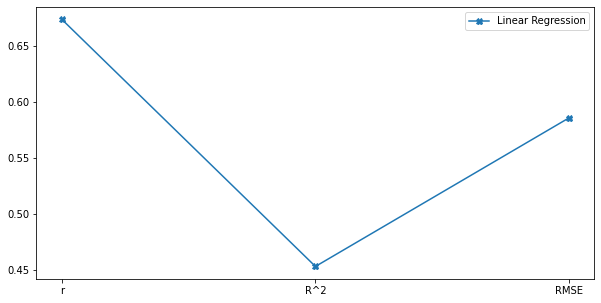

In [36]:
plot = CompareModels()
plot.add(model_name='Linear Regression', y_test=y_test, y_pred=y_pred)
plot.show(figsize=(10, 5))

# 9.1. Linear Regression without Race

In [35]:
features_2 = df_new[["age",
                    "sex_Male",
                    "c_charge_degree_detailed",
                    "priors_count",
                    "juv_fel_count",
                    "juv_misd_count",
                    "juv_other_count"]]

target_2 = df_new.decile_score

In [36]:
#Define the variables considered to implement the model 
x_2 = features_2
y_2 = target_2
#Divide the data in training and test 
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(x_2,y_2, test_size=0.33)

In [39]:
# minmax_scaler = MinMaxScaler()
# X_train_scaled = minmax_scaler.fit_transform(features)

In [40]:
linearreg_without_race = LinearRegression()
linearreg_without_race.fit(X_train_2,y_train_2)
y_pred = linearreg_without_race.predict(X_test_2)

In [41]:
exp_linearreg_without_race = dx.Explainer(linearreg_without_race, X_test_2, y_test_2, verbose=False)
exp_linearreg_without_race.model_performance().result

X does not have valid feature names, but LinearRegression was fitted with feature names


,mse,rmse,r2,mae,mad
LinearRegression,0.337346,0.580815,0.436791,0.474379,0.422687


In [42]:
CompareModels.R2AndRMSE(y_test=y_test_2, y_pred=y_pred)

(0.4367905874015897, 0.580814941758068)

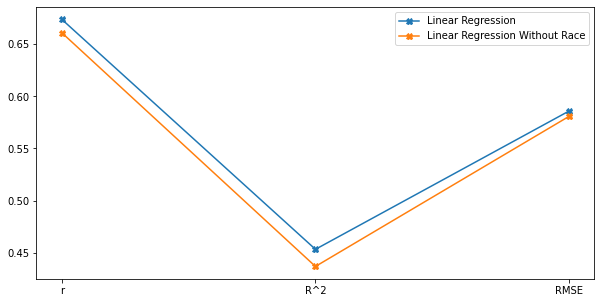

In [43]:
plot.add('Linear Regression Without Race',y_test_2, y_pred)
plot.show(figsize=(10, 5))

# 10. Polynomial Feautures

* The best degree of polynomial should be the degree that generates the lowest RMSE in cross validation set. 

# 10.1. Hyperparameter Tuning

In [47]:
poly_pipe = make_pipeline(PolynomialFeatures(include_bias=False), LinearRegression())

param_grid = {
    "polynomialfeatures__degree": np.arange(2, 6)
}

grid_poly = GridSearchCV(poly_pipe, param_grid, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)

grid_poly.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures(include_bias=False)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': array([2, 3, 4, 5])},
             scoring='neg_root_mean_squared_error')

In [48]:
# Plot and present results
print('Best degree {} with RMSE {}'.format(grid_poly.best_params_, -grid_poly.best_score_))

Best degree {'polynomialfeatures__degree': 2} with RMSE 0.5439482963434147


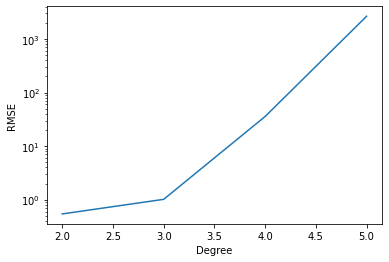

In [49]:
fig = plt.figure()
plt.plot(np.arange(2, 6), abs(grid_poly.cv_results_["mean_test_score"]))
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('RMSE');

In [50]:
exp_polynomial = dx.Explainer(grid_poly, X_test, y_test, verbose=False)
exp_polynomial.model_performance().result

X does not have valid feature names, but PolynomialFeatures was fitted with feature names


,mse,rmse,r2,mae,mad
GridSearchCV,0.317071,0.56309,0.494995,0.449861,0.383037


In [51]:
y_pred = grid_poly.predict(X_test)

In [52]:
CompareModels.R2AndRMSE(y_test, y_pred)


(0.4949951110189551, 0.5630904232958132)

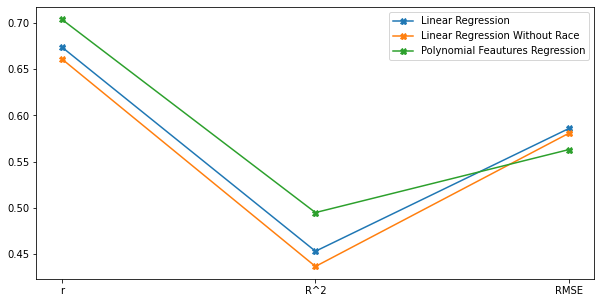

In [53]:
plot.add('Polynomial Feautures Regression',y_test, y_pred)
plot.show(figsize=(10, 5))

# 10.2. Polynomial Features Regression Without Race

In [54]:
degree=2
polyreg_scaled=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg_scaled.fit(X_train_2,y_train_2)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [55]:
exp_polynomial = dx.Explainer(polyreg_scaled, X_test_2, y_test_2, verbose=False)
exp_polynomial.model_performance().result

X does not have valid feature names, but PolynomialFeatures was fitted with feature names


,mse,rmse,r2,mae,mad
LinearRegression,0.304747,0.552039,0.491215,0.437187,0.362652


In [56]:
y_pred = polyreg_scaled.predict(X_test_2)

In [57]:
CompareModels.R2AndRMSE(y_test_2, y_pred)

(0.49121544293564545, 0.5520390356763348)

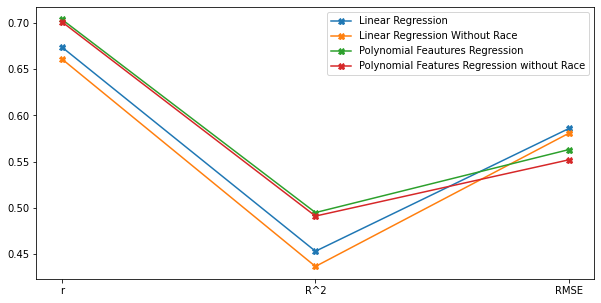

In [58]:
plot.add('Polynomial Features Regression without Race',y_test_2, y_pred)
plot.show(figsize=(10, 5))

# 11. Lasso Regression

# 11.1 Hyperparameter Tuning

In [59]:
# create pipeline 
pipe_lasso = make_pipeline(StandardScaler(), Lasso())

#optimal parameter
param_grid = {'lasso__alpha':np.arange(0.1,1,0.05)}

lasso_cv = GridSearchCV(pipe_lasso, param_grid, scoring='neg_root_mean_squared_error' ,cv = 10)

lasso_cv.fit(X_train, y_train)
print(lasso_cv.best_params_)
print(lasso_cv.best_score_)

{'lasso__alpha': 0.1}
-0.596527810917147


In [60]:
lasso_pred = lasso_cv.predict(X_test)
r2_score(y_test, lasso_pred)

0.4026577278502663

In [61]:
exp_lasso = dx.Explainer(lasso_cv, X_test, y_test, verbose=False)
exp_lasso.model_performance().result

X does not have valid feature names, but StandardScaler was fitted with feature names


,mse,rmse,r2,mae,mad
GridSearchCV,0.375045,0.61241,0.402658,0.518178,0.492591


In [62]:
CompareModels.R2AndRMSE(y_test, lasso_pred)

(0.4026577278502663, 0.6124095784258091)

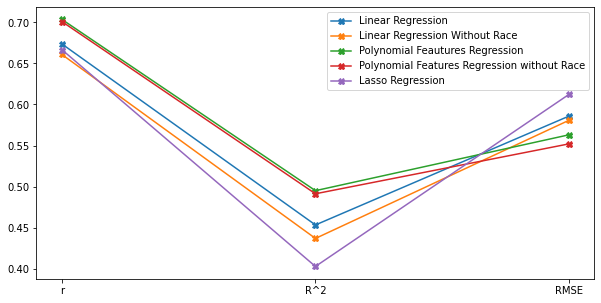

In [63]:
plot.add('Lasso Regression',y_test, lasso_pred)
plot.show(figsize=(10, 5))

# 11.2. Lasso Regression without Race

In [64]:
# create pipeline 
pipe_lasso = make_pipeline(StandardScaler(), Lasso())

#optimal parameter
param_grid = {'lasso__alpha':np.arange(0.1,1,0.05)}

lasso_cv = GridSearchCV(pipe_lasso, param_grid, scoring='neg_root_mean_squared_error' ,cv = 10)

lasso_cv.fit(X_train_2, y_train_2)
print(lasso_cv.best_params_)
print(lasso_cv.best_score_)

{'lasso__alpha': 0.1}
-0.6095325754714933


In [65]:
lasso_pred = lasso_cv.predict(X_test_2)
r2_score(y_test_2, lasso_pred)

0.3999652043970434

In [66]:
exp_ridge = dx.Explainer(lasso_cv, X_test_2, y_test_2, verbose=False)
exp_ridge.model_performance().result

X does not have valid feature names, but StandardScaler was fitted with feature names


,mse,rmse,r2,mae,mad
GridSearchCV,0.359403,0.599503,0.399965,0.506501,0.480644


In [67]:
CompareModels.R2AndRMSE(y_test_2, lasso_pred)

(0.3999652043970434, 0.5995025654311406)

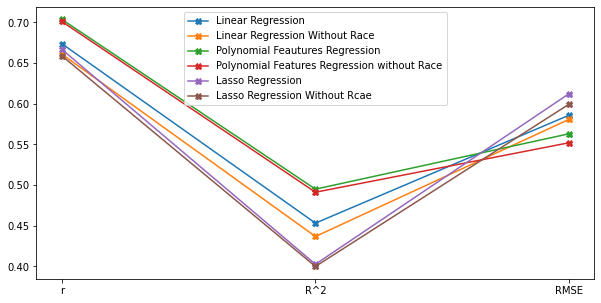

In [68]:
plot.add('Lasso Regression Without Rcae',y_test_2, lasso_pred)
plot.show(figsize=(10, 5))

# 12. Ridge Regression

# 12.1 Hyperparameter Tuning

In [69]:
# create pipeline 
pipe_ridge = make_pipeline(StandardScaler(), Ridge())

#optimal parameter
param_grid = {'ridge__alpha':np.arange(0.1,1,0.05)}

ridge_cv = GridSearchCV(pipe_ridge, param_grid, scoring='neg_root_mean_squared_error' ,cv = 10)

ridge_cv.fit(X_train, y_train)
print(ridge_cv.best_params_)
print(ridge_cv.best_score_)

{'ridge__alpha': 0.1}
-0.5705268744855418


In [70]:
ridge2_pred = ridge_cv.predict(X_test)

In [71]:
exp_ridge = dx.Explainer(ridge_cv, X_test, y_test, verbose=False)
exp_ridge.model_performance().result

X does not have valid feature names, but StandardScaler was fitted with feature names


,mse,rmse,r2,mae,mad
GridSearchCV,0.343297,0.585915,0.453225,0.480551,0.429889


In [72]:
CompareModels.R2AndRMSE(y_test, ridge2_pred)

(0.4532247630679681, 0.5859152052117025)

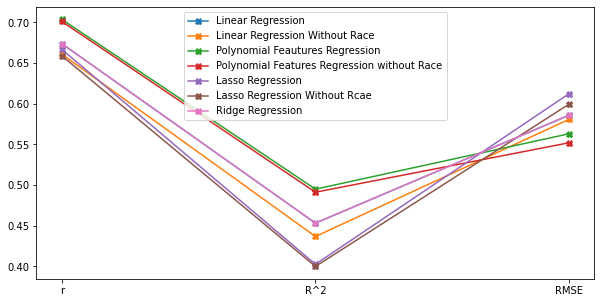

In [73]:
plot.add('Ridge Regression',y_test, ridge2_pred)
plot.show(figsize=(10, 5))

# 12.2 Ridge Regression without Race

In [74]:
# create pipeline 
pipe_ridge = make_pipeline(StandardScaler(), Ridge())

#optimal parameter
param_grid = {'ridge__alpha':np.arange(0.1,1,0.05)}

ridge_cv = GridSearchCV(pipe_ridge, param_grid, scoring='neg_root_mean_squared_error' ,cv = 10)

ridge_cv.fit(X_train_2, y_train_2)
print(ridge_cv.best_params_)
print(ridge_cv.best_score_)

{'ridge__alpha': 0.1}
-0.588104605147578


In [75]:
ridge2_pred = ridge_cv.predict(X_test_2)

In [76]:
exp_ridge = dx.Explainer(ridge_cv, X_test_2, y_test_2, verbose=False)
exp_ridge.model_performance().result

X does not have valid feature names, but StandardScaler was fitted with feature names


,mse,rmse,r2,mae,mad
GridSearchCV,0.337346,0.580815,0.436791,0.474381,0.422688


In [77]:
CompareModels.R2AndRMSE(y_test_2, ridge2_pred)

(0.4367911710998923, 0.5808146407858401)

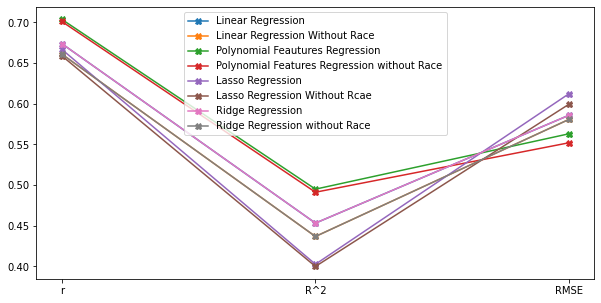

In [78]:
plot.add('Ridge Regression without Race',y_test_2, ridge2_pred)
plot.show(figsize=(10, 5))

# 13. Elastic Net

# 13.1 Hyperparameter Tuning

In [79]:
# create pipeline 
pipe_enet = make_pipeline(StandardScaler(), ElasticNet())

#optimal parameter
param_grid = {'elasticnet__alpha':np.arange(0.1,1,0.05), 'elasticnet__l1_ratio':arange(0.1,1.0,0.1)}

enet_cv = GridSearchCV(pipe_enet, param_grid, scoring='neg_root_mean_squared_error' ,cv = 10)

enet_cv.fit(X_train, y_train)
print(enet_cv.best_params_)
print(enet_cv.best_score_)

{'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.1}
-0.5735938260975484


In [80]:
ElasticNet_pred = enet_cv.predict(X_test)

In [81]:
exp_ElasticNet = dx.Explainer(enet_cv, X_test, y_test, verbose=False)
exp_ElasticNet.model_performance().result

X does not have valid feature names, but StandardScaler was fitted with feature names


,mse,rmse,r2,mae,mad
GridSearchCV,0.347177,0.589217,0.447045,0.489005,0.444981


In [82]:
CompareModels.R2AndRMSE(y_test, ElasticNet_pred)

(0.447044896574322, 0.5892170226419352)

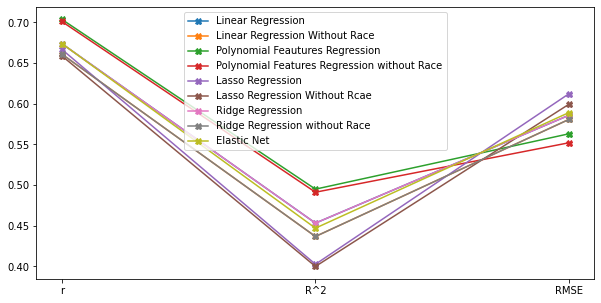

In [83]:
plot.add('Elastic Net',y_test, ElasticNet_pred)

plot.show(figsize=(10, 5))

# 13.2 Elastic Net Regression without Race

In [84]:
enet_cv.fit(X_train_2, y_train_2)
print(enet_cv.best_params_)
print(enet_cv.best_score_)

{'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.1}
-0.591597667489261


In [85]:
ElasticNet_pred = enet_cv.predict(X_test_2)

In [86]:
exp_ElasticNet = dx.Explainer(enet_cv, X_test_2, y_test_2, verbose=False)
exp_ElasticNet.model_performance().result

X does not have valid feature names, but StandardScaler was fitted with feature names


,mse,rmse,r2,mae,mad
GridSearchCV,0.339483,0.582652,0.433223,0.482764,0.447849


In [87]:
CompareModels.R2AndRMSE(y_test_2, ElasticNet_pred)

(0.43322259470727364, 0.5826517999921996)

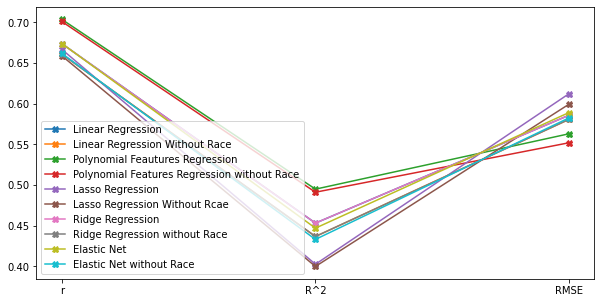

In [88]:
plot.add('Elastic Net without Race',y_test_2, ElasticNet_pred)

plot.show(figsize=(10, 5))

# 14. Random Forest 

In [89]:
#Create the model Random forest and the estimators number 
RF_model = RandomForestRegressor(n_estimators = 100,
                                 random_state = 0,
                                bootstrap = True)

In [90]:
rf_results = cross_validate(RF_model, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')
rf_results["test_score"].mean()

-0.6049861167499212

In [91]:
#Fit the model with the training data 
RF_model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [92]:
y_predict_rfr = RF_model.predict(X_test)

In [93]:
exp_RandomForest = dx.Explainer(RF_model, X_test, y_test, verbose=False)
exp_RandomForest.model_performance().result

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


,mse,rmse,r2,mae,mad
RandomForestRegressor,0.370123,0.608377,0.410498,0.466196,0.371064


In [94]:
#Accuracy of the model 
RF_model.score(X_test, y_test)

0.41049821105266093

In [95]:
#joblib.dump(RF_model, '../../notebooks/Philipp/stored_models/grid_RF_model.pkl')

# 14.1 Random Forest Without Race

In [96]:
rf_results = cross_validate(RF_model, X_train_2, y_train_2, cv=10, scoring='neg_root_mean_squared_error')
rf_results["test_score"].mean()

-0.6118964333300799

In [97]:
RF_model.fit(X_train_2, y_train_2)

RandomForestRegressor(random_state=0)

In [98]:
y_predict_rfr_race = RF_model.predict(X_test_2)

In [99]:
exp_RandomForest = dx.Explainer(RF_model, X_test_2, y_test_2, verbose=False)
exp_RandomForest.model_performance().result

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


,mse,rmse,r2,mae,mad
RandomForestRegressor,0.378037,0.614847,0.368855,0.472023,0.373902


### Hyperparameter Tuning

In [100]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [101]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='neg_root_mean_squared_error', n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_train, y_train)

In [102]:
#joblib.dump(rf_random, '../../notebooks/Philipp/stored_models/grid_rf_regression.pkl')

In [103]:
rf_random = joblib.load('../../notebooks/Philipp/stored_models/grid_rf_regression.pkl')

In [104]:
exp_RandomForest_tuned = dx.Explainer(rf_random, X_test, y_test, verbose=False)
exp_RandomForest_tuned.model_performance().result

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


,mse,rmse,r2,mae,mad
RandomizedSearchCV,0.312053,0.558617,0.502987,0.451844,0.384801


In [105]:
y_pred = rf_random.predict(X_test)

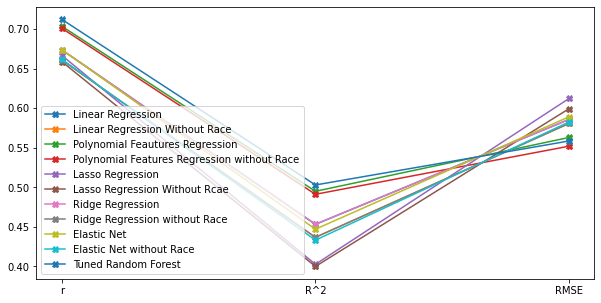

In [106]:
CompareModels.R2AndRMSE(y_test, y_pred)
plot.add('Tuned Random Forest',y_test, y_pred)
plot.show(figsize=(10, 5))

# 14.2 Random Forest Without Race Feature

In [107]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='neg_root_mean_squared_error', n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_train_2, y_train_2)

In [108]:
#joblib.dump(rf_random, '../../notebooks/Philipp/stored_models/grid_rf_regression_without_race.pkl')

In [109]:
rf_random = joblib.load('../../notebooks/Philipp/stored_models/grid_rf_regression_without_race.pkl')

In [110]:
exp_RandomForest_without_race = dx.Explainer(rf_random, X_test_2, y_test_2, verbose=False)
exp_RandomForest_without_race.model_performance().result

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


,mse,rmse,r2,mae,mad
RandomizedSearchCV,0.3085,0.555428,0.484949,0.444165,0.37323


In [111]:
y_pred = rf_random.predict(X_test_2)

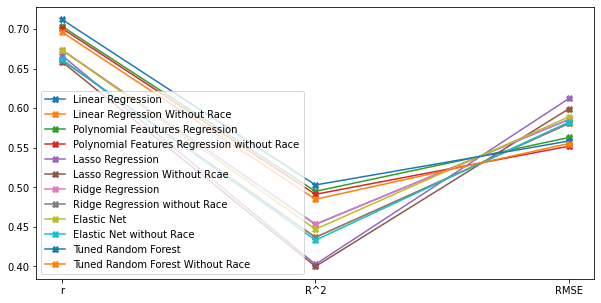

In [112]:
CompareModels.R2AndRMSE(y_test_2, y_pred)
plot.add('Tuned Random Forest Without Race',y_test_2, y_pred)
plot.show(figsize=(10, 5))

# 15. Decision Tree Regressor

In [113]:
# Hyper parameters range intialization for tuning 
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

In [114]:
reg_decision_model=DecisionTreeRegressor()
tuning_model=GridSearchCV(reg_decision_model,param_grid=parameters,scoring='neg_mean_squared_error',cv=10,verbose=2)
#tuning_model.fit(X_train,y_train)

In [115]:
#joblib.dump(tuning_model, '../../notebooks/Philipp/stored_models/grid_decision_tree.pkl')

In [116]:
tuning_model = joblib.load('../../notebooks/Philipp/stored_models/grid_decision_tree.pkl')

Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


In [117]:
exp_decision_tree = dx.Explainer(tuning_model, X_test, y_test, verbose=False)
exp_decision_tree.model_performance().result

X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names


,mse,rmse,r2,mae,mad
GridSearchCV,0.367125,0.605909,0.415272,0.494484,0.415034


In [118]:
y_pred = tuning_model.predict(X_test)

X has feature names, but DecisionTreeRegressor was fitted without feature names


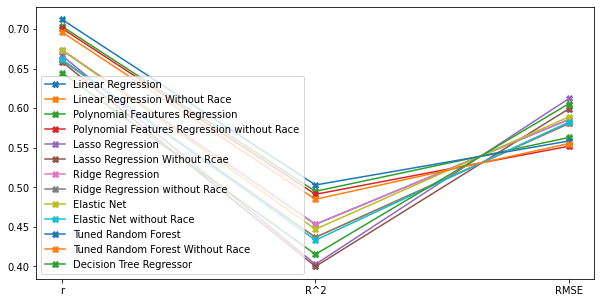

In [119]:
CompareModels.R2AndRMSE(y_test, y_pred)
plot.add('Decision Tree Regressor',y_test, y_pred)
plot.show(figsize=(10, 5))

# 15.1. Decision Tree Regressor Without Race

In [120]:
tuning_model_race=GridSearchCV(reg_decision_model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)
#tuning_model_race.fit(X_train_2,y_train_2)

In [121]:
#joblib.dump(tuning_model_race, '../../notebooks/Philipp/stored_models/grid_decision_tree_without_race.pkl')

In [122]:
tuning_model_race= joblib.load('../../notebooks/Philipp/stored_models/grid_decision_tree_without_race.pkl');

Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


In [123]:
exp_RandomForest_without_race = dx.Explainer(tuning_model_race, X_test_2, y_test_2, verbose=False)
exp_RandomForest_without_race.model_performance().result

X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names


,mse,rmse,r2,mae,mad
GridSearchCV,0.340483,0.583509,0.431554,0.473287,0.358186


In [124]:
y_pred = tuning_model_race.predict(X_test_2)

X has feature names, but DecisionTreeRegressor was fitted without feature names


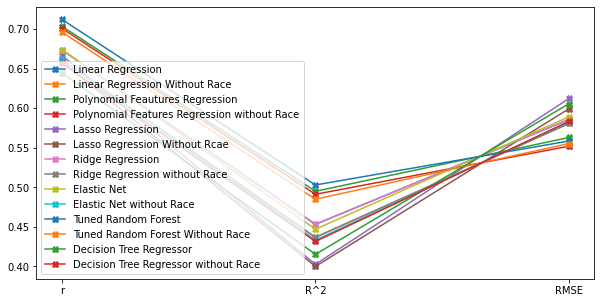

In [125]:
CompareModels.R2AndRMSE(y_test_2, y_pred)
plot.add('Decision Tree Regressor without Race',y_test_2, y_pred)
plot.show(figsize=(10, 5))

# 16. Bagging Regressor 

In [126]:
bag_regressor = BaggingRegressor(tuning_model.best_estimator_, n_estimators=100, random_state=1)

bag_regressor_cv = cross_validate(bag_regressor, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')
bag_regressor_cv["test_score"].mean()

-0.5786750911169987

In [127]:
bag_regressor.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                      max_features='auto',
                                                      min_weight_fraction_leaf=0.1),
                 n_estimators=100, random_state=1)

In [128]:
exp_bag_regressor = dx.Explainer(bag_regressor, X_test, y_test, verbose=False)
exp_bag_regressor.model_performance().result

X does not have valid feature names, but BaggingRegressor was fitted with feature names


,mse,rmse,r2,mae,mad
BaggingRegressor,0.338673,0.581956,0.46059,0.480509,0.406801


## Hyper parameter tuning

In [129]:
params = {'base_estimator': [None, tuning_model.best_estimator_],
          'n_estimators': [20,50,100],
          'max_samples': [0.05, 0.1, 0.2, 0.5],
          'max_features': [0.5,1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

bagging_regressor_grid = RandomizedSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), param_distributions= params, n_iter=10, cv=10, n_jobs=-1, verbose=1)
#bagging_regressor_grid.fit(X_train, y_train)

In [130]:
#joblib.dump(bagging_regressor_grid, '../../notebooks/Philipp/stored_models/bag_regressor_grid.pkl')

In [131]:
bagging_regressor_grid = joblib.load('../../notebooks/Philipp/stored_models/bag_regressor_grid.pkl')

In [132]:
print(bagging_regressor_grid.best_params_)
bagging_regressor_grid.best_score_

{'n_estimators': 50, 'max_samples': 0.05, 'max_features': 1.0, 'bootstrap_features': False, 'bootstrap': False, 'base_estimator': DecisionTreeRegressor(max_depth=5, max_features='auto',
                      min_weight_fraction_leaf=0.1)}


0.479683369135684

In [133]:
exp_bag_regressor_grid = dx.Explainer(bagging_regressor_grid.best_estimator_, X_test, y_test, verbose=False)
exp_bag_regressor_grid.model_performance().result

X does not have valid feature names, but BaggingRegressor was fitted with feature names


,mse,rmse,r2,mae,mad
BaggingRegressor,0.323297,0.568592,0.485078,0.468208,0.398747


In [134]:
y_pred = bagging_regressor_grid.predict(X_test)

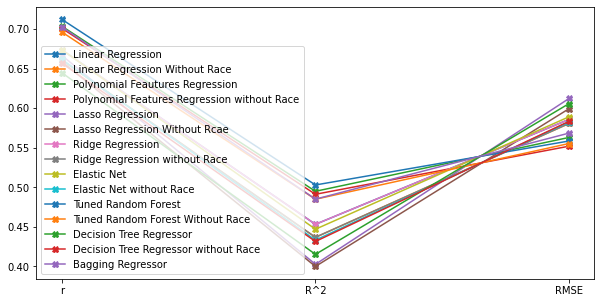

In [135]:
CompareModels.R2AndRMSE(y_test, y_pred)
plot.add('Bagging Regressor',y_test, y_pred)
plot.show(figsize=(10, 5))

# 16.1. Bagging Regressor without Race

In [136]:
bag_regressor = BaggingRegressor(tuning_model_race.best_estimator_, n_estimators=100, random_state=1)

bag_regressor_cv = cross_validate(bag_regressor, X_train_2, y_train_2, cv=10, scoring='neg_root_mean_squared_error')
bag_regressor_cv["test_score"].mean()

-0.5779869098828503

In [137]:
bag_regressor.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                      max_features='auto',
                                                      min_samples_leaf=10,
                                                      min_weight_fraction_leaf=0.1),
                 n_estimators=100, random_state=1)

In [138]:
exp_bag_regressor = dx.Explainer(bag_regressor, X_test, y_test, verbose=False)
exp_bag_regressor.model_performance().result

X does not have valid feature names, but BaggingRegressor was fitted with feature names


,mse,rmse,r2,mae,mad
BaggingRegressor,0.338673,0.581956,0.46059,0.480509,0.406801


In [139]:
params = {'base_estimator': [tuning_model_race.best_estimator_],
          'n_estimators': [100, 250],
          'max_samples': [0.05, 0.1, 0.2, 0.5],
          'max_features': [0.5,1.0],
          'bootstrap': [True],
          'bootstrap_features': [True]}

bagging_regressor_grid = RandomizedSearchCV(BaggingRegressor(random_state=1), param_distributions= params, n_iter=10, cv=10, n_jobs=-1, verbose=1)
#bagging_regressor_grid.fit(X_train_2, y_train_2)

In [140]:
#joblib.dump(bagging_regressor_grid, '../../notebooks/Philipp/stored_models/bag_regressor_grid_wo_race.pkl')

In [141]:
bagging_regressor_grid = joblib.load('../../notebooks/Philipp/stored_models/bag_regressor_grid_wo_race.pkl')

In [142]:
print(bagging_regressor_grid.best_params_)
bagging_regressor_grid.best_score_

{'n_estimators': 250, 'max_samples': 0.1, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': True, 'base_estimator': DecisionTreeRegressor(max_depth=5, max_features='auto', min_samples_leaf=10,
                      min_weight_fraction_leaf=0.1)}


0.415988436284566

In [143]:
exp_bag_regressor_grid = dx.Explainer(bagging_regressor_grid.best_estimator_, X_test_2, y_test_2, verbose=False)
exp_bag_regressor_grid.model_performance().result

X does not have valid feature names, but BaggingRegressor was fitted with feature names


,mse,rmse,r2,mae,mad
BaggingRegressor,0.350902,0.59237,0.414159,0.504506,0.499861


In [144]:
y_pred = bagging_regressor_grid.predict(X_test_2)

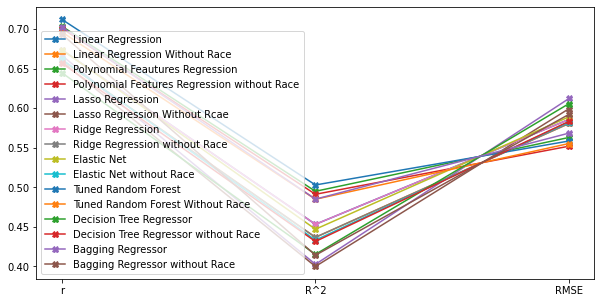

In [145]:
CompareModels.R2AndRMSE(y_test, y_pred)
plot.add('Bagging Regressor without Race',y_test_2, y_pred)
plot.show(figsize=(10, 5))

# 17. Xgboost Regressor

In [146]:
# xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', gamma=0, learning_rate=0.1, 
#                           max_depth=3, min_child_weight=1, n_estimators=100, objective='reg:linear', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
#                           max_delta_step=0, subsample=1, verbosity=0, silent = True
#                         )
# xg_reg.fit(X_train,y_train)
# y_pred = xg_reg.predict(X_test)

In [147]:
# exp_xgreg = dx.Explainer(xg_reg, X_test, y_test, verbose=False)
# exp_xgreg.model_performance().result

## Hyper parameter tuning

In [148]:
# model tuning
import time
scoring_reg ='neg_root_mean_squared_error'

# A parameter grid for XGBoost
params = {
    'n_estimators':[100,150,200],
    'min_child_weight':[2,3,4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
    'learning_rate':[i/10.0 for i in range(2,11)],
    
}

reg = XGBRegressor()

# run randomized search
n_iter_search = 250
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring=scoring_reg)

# start = time.time()
# random_search.fit(X_train, y_train)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time.time() - start), n_iter_search))

In [149]:
# #plug the best estimatior to predict y and find r2 score, mse
# best_regressor = random_search.best_estimator_
# y_pred = best_regressor.predict(X_test)
# r2_score(y_test,y_pred)

In [150]:
# exp_xgreg = dx.Explainer(best_regressor, X_test, y_test, verbose=False)
# exp_xgreg.model_performance().result

* Tuning the number of boosting round (n_estimator)

In [151]:
# params = {
#     'n_estimators': np.arange(80,120,5)
# }
# gsearch = GridSearchCV(estimator = random_search.best_estimator_,param_grid = params, cv=5, scoring=scoring_reg)
# gsearch.fit(X_train,y_train)
# gsearch.best_params_, gsearch.best_score_

In [152]:
# params = {
#     'n_estimators': np.arange(105,120,1)
# }
# gsearch = GridSearchCV(estimator = random_search.best_estimator_,param_grid = params, cv=5, scoring=scoring_reg)
# gsearch.fit(X_train,y_train)
# gsearch.best_params_, gsearch.best_score_

In [153]:
# gsearch.best_estimator_

In [154]:
# params = {
#     'subsample':[0.4,0.7,0.1],
#     'colsample_bytree':[0.6,0.9,0.1],
#     'reg_alpha':[0,1,0.1],
#     'learning_rate':[0.01,0.1,0.01], 
#     'max_depth':[1,3,1],
#     'min_child_weight':[1,4,1]
# }
# gsearch = GridSearchCV(estimator = gsearch.best_estimator_,param_grid = params, cv=5, scoring=scoring_reg) #here we plug in gsearch best estimator as result from above
# gsearch.fit(X_train,y_train)
# gsearch.best_params_, gsearch.best_score_

In [138]:
#joblib.dump(gsearch, '../../notebooks/Philipp/stored_models/xgboost_regressor.pkl')

In [155]:
gsearch = joblib.load('../../notebooks/Philipp/stored_models/xgboost_regressor.pkl')

Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


In [156]:
best_regressor = gsearch.best_estimator_
y_pred = best_regressor.predict(X_test)
r2_score(y_test,y_pred)

0.5173000903029545

In [136]:
exp_xgreg = dx.Explainer(best_regressor, X_test, y_test, verbose=False)
exp_xgreg.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,0.30245,0.549954,0.518282,0.435211,0.353792


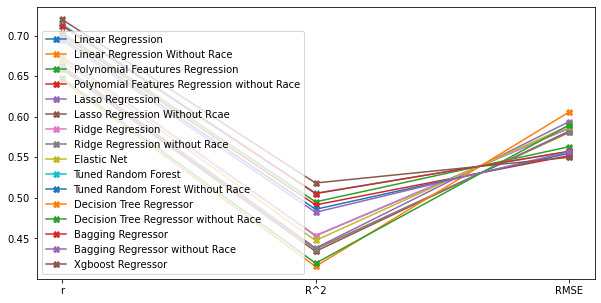

In [137]:
CompareModels.R2AndRMSE(y_test, y_pred)
plot.add('Xgboost Regressor',y_test, y_pred)
plot.show(figsize=(10, 5))

# 17.1 Xgboost Regressor without Race

In [139]:
xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', gamma=0, learning_rate=0.1, 
                          max_depth=3, min_child_weight=1, n_estimators=100, objective='reg:linear', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, importance_type='gain',
                          max_delta_step=0, subsample=1, verbosity=0, silent = True
                        )
# xg_reg.fit(X_train_2,y_train_2)
# y_pred = xg_reg.predict(X_test_2)

In [140]:
# exp_xgreg = dx.Explainer(xg_reg, X_test_2, y_test_2, verbose=False)
# exp_xgreg.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,0.306592,0.553707,0.488136,0.435085,0.352999


In [141]:
# model tuning
import time

# A parameter grid for XGBoost
params = {
    'n_estimators':[100,150,200],
    'min_child_weight':[2,3,4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
    'learning_rate':[i/10.0 for i in range(2,11)],
    
}

reg = XGBRegressor()

# run randomized search
n_iter_search = 250
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring=scoring_reg)

start = time.time()
# random_search.fit(X_train_2, y_train_2)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 348.57 seconds for 250 candidates parameter settings.


In [142]:
# #plug the best estimatior to predict y and find r2 score, mse
# best_regressor = random_search.best_estimator_
# y_pred = best_regressor.predict(X_test_2)
# r2_score(y_test_2,y_pred)

0.4888606729986136

In [143]:
# exp_xgreg = dx.Explainer(best_regressor, X_test_2, y_test_2, verbose=False)
# exp_xgreg.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,0.306158,0.553315,0.488861,0.43702,0.357541


In [144]:
params = {
    'n_estimators': np.arange(80,120,5)
}
gsearch = GridSearchCV(estimator = random_search.best_estimator_,param_grid = params, cv=5, scoring=scoring_reg)
# gsearch.fit(X_train_2,y_train_2)
# gsearch.best_params_, gsearch.best_score_

({'n_estimators': 80}, -0.5504841044881675)

In [404]:
params = {
    'n_estimators': np.arange(105,120,1)
}
gsearch = GridSearchCV(estimator = random_search.best_estimator_,param_grid = params, cv=5, scoring=scoring_reg)
# gsearch.fit(X_train_2,y_train_2)
# gsearch.best_params_, gsearch.best_score_

({'n_estimators': 118}, -0.5513853839944698)

In [405]:
params = {
    'subsample':[0.4,0.7,0.1],
    'colsample_bytree':[0.6,0.9,0.1],
    'reg_alpha':[0,1,0.1],
    'learning_rate':[0.01,0.1,0.01], 
    'max_depth':[1,3,1],
    'min_child_weight':[1,4,1]
}
gsearch = GridSearchCV(estimator = gsearch.best_estimator_,param_grid = params, cv=5, scoring=scoring_reg) #here we plug in gsearch best estimator as result from above
# gsearch.fit(X_train_2,y_train_2)
# gsearch.best_params_, gsearch.best_score_

({'colsample_bytree': 0.6,
  'learning_rate': 0.1,
  'max_depth': 3,
  'min_child_weight': 1,
  'reg_alpha': 0.1,
  'subsample': 0.7},
 -0.5494474731858111)

In [409]:
#joblib.dump(gsearch, '../../notebooks/Philipp/stored_models/xgboost_regressor_w_race.pkl')

In [31]:
gsearch = joblib.load('../../notebooks/Philipp/stored_models/xgboost_regressor_w_race.pkl')

Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


In [406]:
best_regressor = gsearch.best_estimator_
y_pred = best_regressor.predict(X_test_2)
r2_score(y_test_2,y_pred)

0.489131471117624

In [407]:
exp_xgreg = dx.Explainer(best_regressor, X_test_2, y_test_2, verbose=False)
exp_xgreg.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,0.305995,0.553168,0.489131,0.435965,0.354159


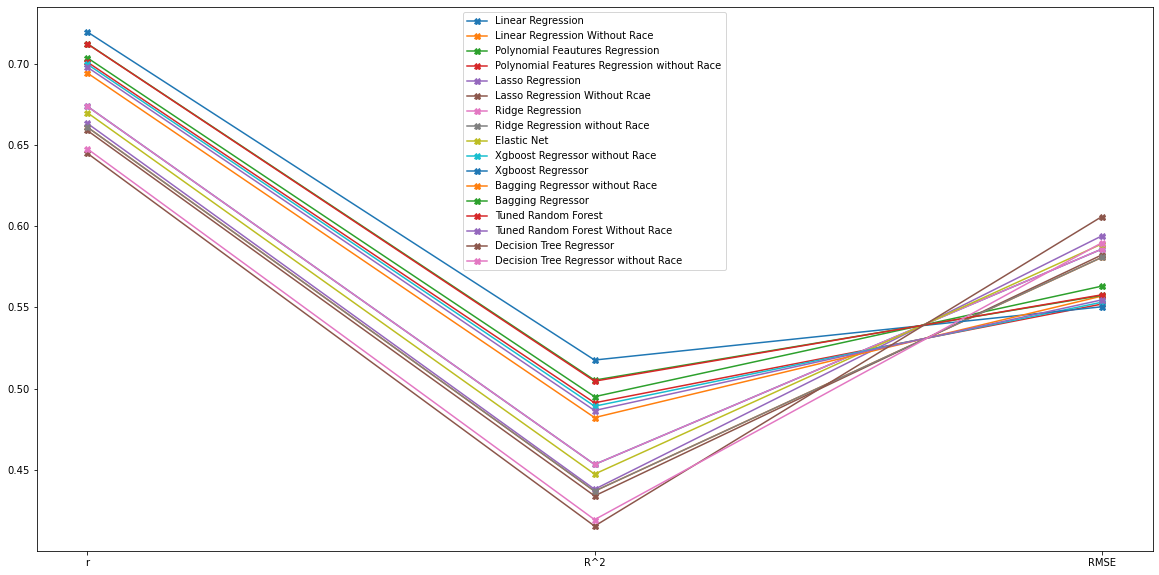

In [408]:
CompareModels.R2AndRMSE(y_test_2, y_pred)
plot.add('Xgboost Regressor without Race',y_test_2, y_pred)
plot.show(figsize=(20, 10))

# 18. Comparison of the Model

* Chosen Metric = RMSE. One of the most commonly used loss functions for regression. An estimate to measure the error of the numerical predicitve model. In short, measure the error rate of a regression model. 

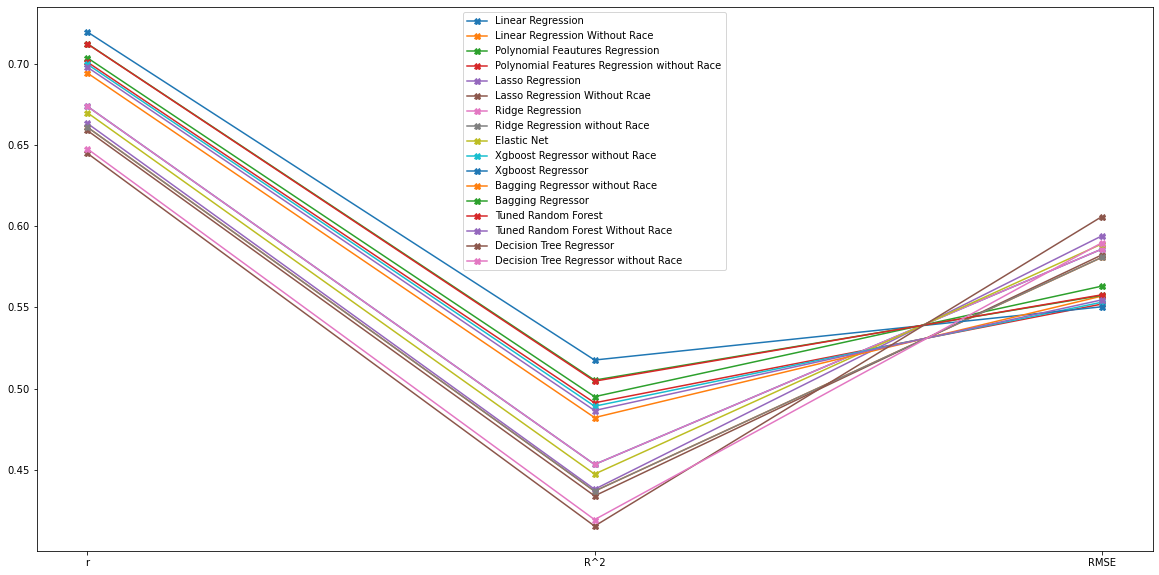

In [410]:
plot.show(figsize=(20, 10))

* To sum up the model analysis, as you can see from the graph above we have developed 17 models.

* After inspecting the above graph, we will proceed with Xgboost Regressor Without Race as the most accurate model.

* The first reason being that a model with the race feature would induce racism.

* The second reason being that it had the lowest RMSE score.

* After inspecting the above graph, we will proceed with Xgboost Regressor Without Race as the best model.

# 19. Shap Values

In [29]:
shap.initjs()

In [32]:
best_est_reg_race = gsearch.best_estimator_
xgb_reg = best_est_reg_race

In [1]:
#compute SHAP values
explainer = shap.TreeExplainer(xgb_reg)
shap_values= explainer.shap_values(X_test_2)

NameError: name 'shap' is not defined

* Global Interpretability

* Variable Importance Plot - Global Interpretability

# 19.1 Individual SHAP Value Plot

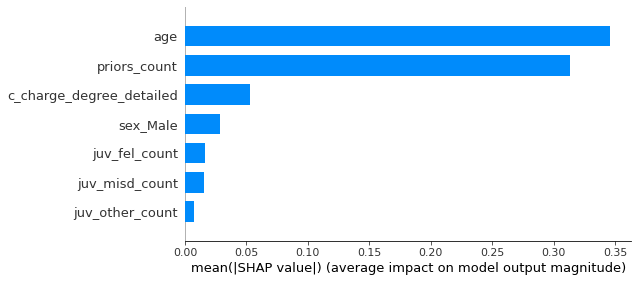

In [429]:
shap.summary_plot(shap_values, X_test_2, plot_type='bar')

With this plot we are able to see that the features with significant influence affecting the model predection are Age and priors_count. 

In [428]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_2.iloc[0,:])

The visualization above shows the features contribuition to push the model output from the base value to the model output. Features pushing the prediction higher as c_charge_degree_detailed and age and those pushing the prediction lower like priors_count and sex_male showed in blue.

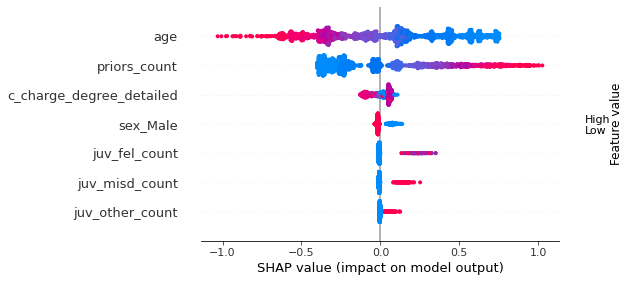

In [418]:
shap.summary_plot(shap_values, X_test_2)

* The plot above represents every data point in our dataset. It plots a single SHAP value for every data point in dataset. 

* Each X-axis belongs to a single prediction made by the model. Each Y-axis represents a feature used in the model.
* In this graph the red color means higher value of a feature and the blue color means lower value of a feature.
* We could see that the model did not ignore any of the feautures.

* According to the Summary plot, the lower the age, the higher Decile Score the person is predicted to get. 

* This does make sense, as usually the younger criminal have such a hard time reinstate into the society and it's hard to leave the wrong path. 

* The second most important feature is the "priors_count" feature. The higher the number of prior arrests of an individual, the higher his or her "decile_score" is predicted to be. This makes perfect sense.

* One interesting insight from the graph above, from looking at the feature "sex_Male" is that we can see that females are more likely to have higher decile score.

* We can see that also from looking at the impact of juvenile crime feautures in the model; the higher values of "juv_fel_count", "juv_misd_count", "juv_other_count" increase the predicted Decile Score of the individual.

In [425]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train_2)

# 19.2 SHAP Partial Dependence Plot 

In the partial dependence plots below , we can observe the dependence between the target function and a set of target features (age, priors_count, c_charge_degree_detailed and sex), marginalizing over the values of all other features (the complement features).

* For the first Partial Dependence Plot we could infered that there is a negative linear relationship between the age and the target variable and also that after 70 years old the individual represent a minimal risk.

* For the second Partial Dependece Plot we could observe a positive linear relationship until the priors_count reaches 15. The individual has more than 15 priors_count the effect in the decile_score becomes constant. 

* For the third Partial Dependence Plot we could conclude that at the c_charge_degree_detailed 3 or 5 the effect in the decile_score has a representative increase. "F1":1,"F2":2,"F3":3,"M1":4,"M2":5 

* Finally for the last Partial Dependence Plot, considering a categorical feature, there is a drastic decile_score difference between the two genders. 

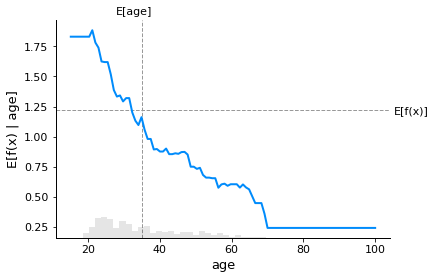

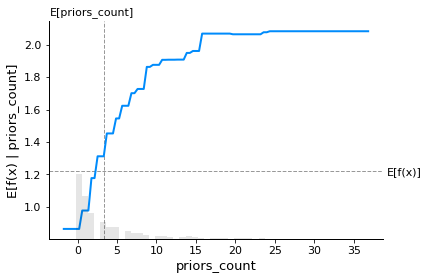

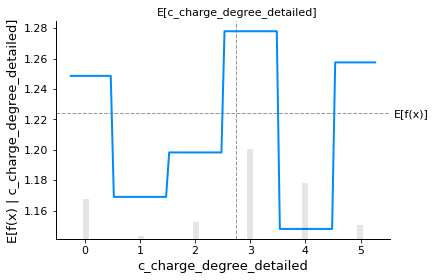

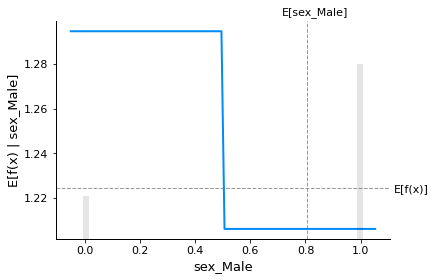

In [437]:
features_list = [ "age","priors_count", "c_charge_degree_detailed","sex_Male"]
for i in features_list:
    shap.plots.partial_dependence(
    i, best_regressor.predict, X_test_2.values, ice=False,
    model_expected_value=True, feature_expected_value=True, feature_names=X_test_2.columns
    )

# 19.3 SHAP Dependence Plot 

The partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model. It tells whether the relationship between the target and a feature is linear, monotonic or more complex. 
The graphs below, plot SHAP value for feature Age against value for feature priors_count and also all the way around. Finally it also plots c_charge_degree_detailed against priors_count. 

* In the first graph we could observe a simple linear relationship between age and priors_count. 

* In the graph we could also interpret that Age and priors_count have a negative linear relationship.

* For the second case the interpretation goes all the way around, priors_count and Age have a positive linear relationship.

* Previously, we have enconded the detailed charge degrees in the following way (the missing values were encoded as zeros): 

"F1":1,"F2":2,"F3":3,"M1":4,"M2":5 

For the last graph, as we can see is not a linear regression relationship between c_charge_degree_detailed and priors_count. In fact we can not even detect any patterns between those features. 
 

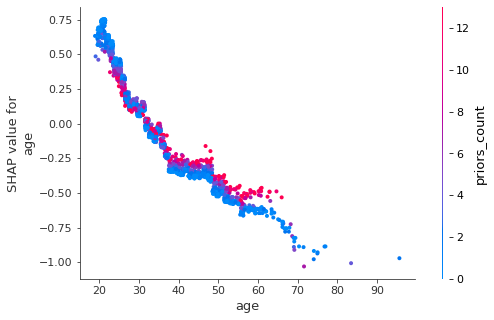

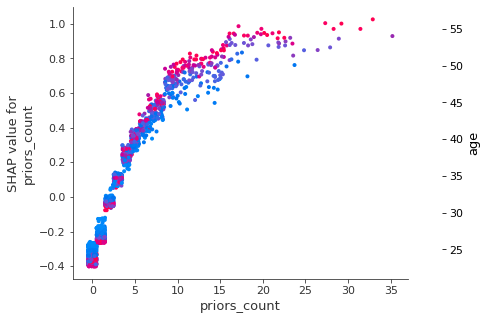

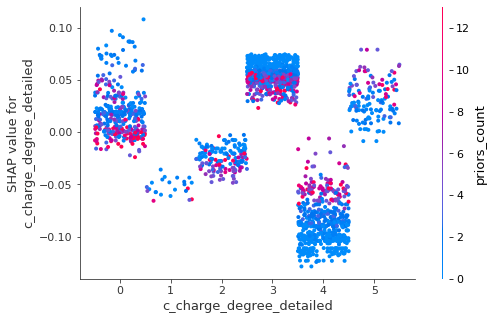

In [430]:
features_list = [ "age","priors_count", "c_charge_degree_detailed"]

for i, feature in enumerate(features_list):
    shap.dependence_plot(feature, shap_values, X_test_2, x_jitter=10)

# 19.4 Local Interpretability

## Individual SHAP Value Points

The below graphs describes different rows of data in our dataset. The “base value” is the mean for the output. This is the baseline for predictions, and then the prediction is altered accordingly based on the value of each feature.

In [432]:
#Select random case from test data
np.random.seed(42)
rand_row = np.random.randint(0,X_test_2.shape[0],1)
pd.concat([X_test_2.iloc[rand_row,:],y_test_2[X_test_2.iloc[rand_row,:].index]], axis=1)

,age,sex_Male,c_charge_degree_detailed,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score
2557,24,1,3.0,0,0,0,0,1.098612


In [433]:
shap.force_plot(explainer.expected_value, shap_values[rand_row,:], features=X_test_2.iloc[rand_row,:])

In [439]:
ind= 78 # chosen basedn on multiple sample plot
display(pd.concat([X_test_2,y_test_2.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_2.iloc[ind,:])

,age,sex_Male,c_charge_degree_detailed,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score
78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [440]:
ind= 39 # chosen basedn on multiple sample plot
display(pd.concat([X_test_2,y_test_2.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_2.iloc[ind,:])

,age,sex_Male,c_charge_degree_detailed,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score
39,49.0,1.0,4.0,0.0,0.0,0.0,0.0,1.098612


In [441]:
ind= 96 # chosen basedn on multiple sample plot
display(pd.concat([X_test_2,y_test_2.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value, shap_values[ind,:], features=X_test_2.iloc[ind,:])

,age,sex_Male,c_charge_degree_detailed,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
